# FELADAT

Készítsen egy alkalmazást, amely az asztalra (sötét felületre) kiszórt, egymást lényegileg nem fedő kártyalapokat (nevét) tud felismerni (használhat homográfiát, mintaegyezés vizsgálatot, vagy más ismertetett módszert)!

A doc könyvtárban található a dokumentáció.

pics2 könyvtár: ez tartalmazza a feldolgozandó képeket (20 darab), amelyen a kártyák kék háttér előtt vannak.

pics1 könyvtár: ebben a könyvtárban egy másik 20 képből álló képsorozat van, amelyet ellenőrzéshez használtam. Ezek más háttér előtt készültek.

pics3 könyvtár: ebben a könyvtárban egy másik kártya pakliról készült képek találhatóak, amit tesztelésre használtam.

refs3 könyvtár: ebben az 52 kártyalap képe van egyesével, ezek szolgáltak referenciaként.

results/pic2: a pic2 összes képének feldolgozott, annotált változata.

results/pic1: a pic1 összes képének feldolgozott, annotált változata.

results/pic3: a pic3 összes képének feldolgozott, annotált változata.

probalkozasok könyvtár: ezek a feladat elkészítése során született sikertelen próbálkozások, tesztelések, más módszerek kipróbálásához használt kódok. Nem képezik a beadandó feladat részét.

Colabhoz, lokális futtatáshoz nem kell

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Python Importok

In [17]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.spatial.distance import pdist, squareform

Ez a függvény csak a megjelentést segíti. Lehet vele skálázni, hogy a nagyobb képek is kiférjenek a képernyőre, illetve a kisebbeket nagyítani (de csak a megjelenítés céljára, maga a kép nem módosul).

In [18]:
def display_scaled(pic, scale=1):
    h, w = pic.shape[:2]
    display(Image.fromarray(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)).resize((int(w * scale), int(h * scale)), Image.LANCZOS))

Ez a függvény a hisztogram megjelentését végzi a matplotlib segítségével.

In [19]:
def show_gray_hist(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).ravel()
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.plot(hist)
    plt.xlim([0, 255])
    plt.show()

Az óra járásával ellentétesen rendezi a kapott pontokat. Ennek tulajdonképpen csak a megjelenítéskor van jelentősége, hogy a feliratok mindig a bal felső sarokhoz igazodjanak amennyire lehet.

In [20]:
def order_ccw(pts):
    c = pts.mean(axis=0)
    angles = np.arctan2(pts[:, 1] - c[1], pts[:, 0] - c[0])
    pts = pts[np.argsort(angles)]
    tl_idx = np.argmin(pts.sum(axis=1))
    return np.roll(pts, -tl_idx, axis=0).astype(np.float32)

Visszaadja a kapott sarok pontok alapján a kártyalapot leíró sarkok által meghatározott oldal hosszokat, azok arányát, a diagonálisok hosszát és azok arányát. Ezeket a találatok szűrésekor használom fel a nagyon torzult találatok eltávoltására.

In [21]:
def calculate_side_lengths(corners):
    corners = np.squeeze(corners)
    side_lengths = []
    diagonal_lengths = []

    for i in range(4):
        point1 = corners[i]
        point2 = corners[(i + 1) % 4]
        length = np.linalg.norm(point2 - point1)
        side_lengths.append(length)
    shortest = min(side_lengths)
    longest = max(side_lengths)
    side_aspect = longest / shortest

    diagonal1 = np.linalg.norm(corners[0] - corners[2])
    diagonal_lengths.append(diagonal1)
    diagonal2 = np.linalg.norm(corners[1] - corners[3])
    diagonal_lengths.append(diagonal2)
    shortest = min(diagonal_lengths)
    longest = max(diagonal_lengths)
    diag_aspect = longest / shortest

    return side_lengths, side_aspect, diagonal_lengths, diag_aspect

Ez a függvény a megadott könyvtárban található referencia képeket dolgozza fel, és SIFT kulcspontokat és leírókat számol minden képre. Az eredmény egy lista, amely minden képhez tartalmazza a nevét, kulcspontjait, leíróit és az eredeti színes képet. Készít egy bináris maszkolást és a maszkolt képet használja a kulcspontok detektálásához.

In [22]:
def process_reference_images(ref_dir, contrastThreshold=0.01, edgeThreshold=15, nOctaveLayers=11, sigma=1.75, verbose=0):
    
    sift = cv2.SIFT_create(contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, nOctaveLayers=nOctaveLayers, sigma=sigma)
    ref_data = []

    for file in Path(ref_dir).rglob("*"):
        
        if not file.is_file():
            continue
        
        card_to_search_color = cv2.imread(str(file))

        if card_to_search_color is None:
            continue
        if verbose > 2: display_scaled(card_to_search_color, 0.5)

        card_to_search_gray = cv2.cvtColor(card_to_search_color, cv2.COLOR_BGR2GRAY)
        if verbose > 2: display_scaled(card_to_search_gray, 0.5)
        if verbose > 3: show_gray_hist(card_to_search_gray)

        _, card_to_search_thresh = cv2.threshold(card_to_search_gray, 150, 255, cv2.THRESH_BINARY)
        card_to_search_masked = cv2.bitwise_and(card_to_search_gray, card_to_search_gray, mask=card_to_search_thresh)
        if verbose > 2: display_scaled(card_to_search_thresh, 0.5)
        if verbose > 3: show_gray_hist(card_to_search_thresh)
        if verbose > 2: display_scaled(card_to_search_masked, 0.5)
        if verbose > 3: show_gray_hist(card_to_search_masked)

        ref_kp, ref_des = sift.detectAndCompute(card_to_search_masked, None)
        if verbose > 0: print(f'{str(file)} -> {len(ref_kp)} key-points found')

        if verbose > 1: 
            ref_kp_img = cv2.drawKeypoints(card_to_search_color, ref_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            display_scaled(ref_kp_img, 0.5)

        card_face = file.name.split(".")[0]
        ref_data.append((card_face, ref_kp, ref_des, card_to_search_color))
    
    return ref_data

Ez a függvény a egz konkrét képet dolgoz fel, amelyen a kártyalapokat keressük. SIFT kulcspontokat és leírókat számol minden képre. Az eredmény egy lista, amely tartalmazza a kép kulcspontjait, leíróit és az eredeti színes valmint a maszkolt képet. Készít egy bináris maszkolást és a maszkolt képet használja a kulcspontok detektálásához.

In [23]:
def process_image(img_name, contrastThreshold=0.01, edgeThreshold=15, nOctaveLayers=11, sigma=1.75, verbose=0):
    
    sift = cv2.SIFT_create(contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, nOctaveLayers=nOctaveLayers, sigma=sigma)

    img_to_process_color = cv2.imread(img_name)
    if verbose > 2: display_scaled(img_to_process_color, 0.2)

    img_to_process_gray = cv2.cvtColor(img_to_process_color, cv2.COLOR_BGR2GRAY)
    if verbose > 2: display_scaled(img_to_process_gray, 0.2)
    if verbose > 3: show_gray_hist(img_to_process_gray)

    _, img_to_process_thresh = cv2.threshold(img_to_process_gray, 150, 255, cv2.THRESH_BINARY)
    img_to_process_masked = cv2.bitwise_and(img_to_process_gray, img_to_process_gray, mask=img_to_process_thresh)
    if verbose > 2: display_scaled(img_to_process_thresh, 0.2)
    if verbose > 3: show_gray_hist(img_to_process_thresh)
    if verbose > 2: display_scaled(img_to_process_masked, 0.2)
    if verbose > 3: show_gray_hist(img_to_process_masked)
    
    kp, des = sift.detectAndCompute(img_to_process_masked, None)

    if verbose > 0: print(f'{len(kp)} key-points found in {img_name}')

    if verbose > 1: 
        kp_img = cv2.drawKeypoints(img_to_process_color, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        display_scaled(kp_img, 0.5)

    return kp, des, img_to_process_color, img_to_process_masked

Ez a függvény BFMatcher használatával előálltja az összes találatot és a jó találatokat a kapott descriptorok alapján.

In [24]:
def get_matches(des_reference, des_image, distance_ratio=0.75, verbose=0):
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = matcher.knnMatch(des_reference, des_image, k=2)
    good_matches = [m for m, n in matches if m.distance < distance_ratio * n.distance]
    
    if verbose > 0: print(f"{len(good_matches)} good matches out of {len(matches)} total matches")
    
    return matches, good_matches

Ez a függvény három különböző módszerrel próbálja meg megtalálni a legjobb transzformációs mátrixot (homográfiát) két pontkészlet között, és kiválasztja azt, amelyik a legtöbb megbízható illeszkedést eredményezi. Erre azért volt szükségem mert a feldolgozott képektől (az azon található kártyakép dőlésétől leginkább) függően más módszerek működtek jól.

In [25]:
def findHomography(src_pts, dst_pts, max_iters=10000):
    M1, mask1 = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=max_iters, confidence=0.995)
    M1 = np.vstack([M1, [0, 0, 1]])
    name = "estimateAffine2D (RANSAC)"
    ret_M = M1
    ret_mask = mask1
    
    M2, mask2 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0, maxIters=max_iters, confidence=0.995)
    if np.sum(mask2) > np.sum(ret_mask):
        name = "findHomography (RANSAC)"
        ret_M = M2
        ret_mask = mask2

    M3, mask3 = cv2.findHomography(src_pts, dst_pts, cv2.USAC_ACCURATE, 2.0, maxIters=max_iters, confidence=0.995)
    if np.sum(mask3) > np.sum(ret_mask):
        name = "findHomography (USAC_ACCURATE)"
        ret_M = M3
        ret_mask = mask3
    
    return name, ret_M, ret_mask

Ez a függvény minden egyes referencia képet megpróbál megtalálni a feldolgozandó képen. A legjobb hommográfia alapján el is végzi a perspektíva átalakítást.

In [26]:
def find_cards(reference_card_data, kp, des, distance_ratio = 0.75, max_iters=10000, verbose=0):

    found = []

    for ref_name, ref_kp, ref_des, ref_img_color in reference_card_data:
        if verbose > 0: print(f"processing {ref_name}...")

        matches, good_matches = get_matches(ref_des, des, distance_ratio=distance_ratio, verbose=verbose)
        
        if len(good_matches) >= 8:
            if verbose > 0: print(f'{len(good_matches)} out of {len(matches)} is {len(good_matches) / len(matches)} rate')

            src_pts = np.float32([ref_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            if verbose > 0: print(f"trying to match src_pts.shape={src_pts.shape} dst_pts.shape={dst_pts.shape}")

            h, w = ref_img_color.shape[:2]
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
            name, M, mask = findHomography(src_pts, dst_pts, max_iters=max_iters)
            if verbose > 0: print(f"{name} found {np.sum(mask)} inliers out of {len(good_matches)} good matches")
            dst = cv2.perspectiveTransform(pts, M)
            found.append((ref_name, name, dst, np.sum(mask), len(good_matches), len(matches), good_matches))
    
    return found

A legtöbb esetben a find_cards visszaad több találatot is ugyan arra a képre, mivel sok esetben a referencia képek közötti különbségek kicsik, mert az alacsony számértékű képeken sok a fehér terület. Ezért amikor a találatokat megpróbálom csoportosítani, hogy melyek esnek ugyan arra a területre, dinamikusan megpróbálom a találatok alapján eldönteni, hogy milyen távol kell lennie egymástól a középpontoknak ahhoz, hogy különböző lapként értelmezzem őket.

In [27]:
def get_card_width_and_height(quads):
    widths = []
    heights = []

    for quad in quads:
        quad = order_ccw(quad.reshape(4, 2))

        top_width = np.linalg.norm(quad[1] - quad[0])
        bottom_width = np.linalg.norm(quad[2] - quad[3])
        left_height = np.linalg.norm(quad[3] - quad[0])
        right_height = np.linalg.norm(quad[2] - quad[1])

        avg_width = (top_width + bottom_width) / 2
        avg_height = (left_height + right_height) / 2

        widths.append(avg_width)
        heights.append(avg_height)

    return np.mean(widths), np.mean(heights)

Ez a függvény megpróbálja csoportokba sorolni a lapok elhelyezkedését leíró koordináták alapján azokat. A csoportosítás alapja az, hogy egy adott határértéknél közelebb vagy messzebb van-e középpontjuk.

In [28]:
def group_by_centroid_proximity(quads, threshold=25):
    centroids = np.array([quad.reshape(4, 2).mean(axis=0) for quad in quads])
    distances = squareform(pdist(centroids))
   
    n = len(quads)
    group_labels = -np.ones(n, dtype=int)
    group_id = 0
    
    for i in range(n):
        if group_labels[i] != -1:
            continue
        group_labels[i] = group_id
        for j in range(i + 1, n):
            if distances[i, j] < threshold:
                group_labels[j] = group_id
        group_id += 1
        
    return group_labels

Ennek a függvénynek a feladata az, hogy a kapott találatokból kiszűrje azokat, amelyek szinte biztosan nem felelnek meg egy kártyalapnak. Például kiszűri ha a találat egyik sarka a képernyőn kívülre esik, ha nem konvex a találat, ha túl kicsi vagy túl nagy a kártyalap által lefedett terület, ha nem megfelelő az oldalak vagy az átlók aránya. Ezt követően előállítja az egyes kártyalapok végső adatait az alapján, hogy ha egy területre több taLálat esik, akkor azt veszi figyelembe, amely a legtöbb inlinert eredményezte.

In [29]:
def refine_found_data(found_data, img_to_process_color, verbose=0):
    refined = {}
    refined_final = {}
    ret = []

    for ref_name, hname, dst, l_mask, l_good_matches, l_matches, good_matches in found_data:
        h, w = img_to_process_color.shape[:2]
        cntrarea = cv2.contourArea(dst)

        if cv2.isContourConvex(dst) == False:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: not convex")
            continue

        if any(dst[dst<0]) or any(dst[:, :, 0] > w) or any(dst[:, :, 1] > h):
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: dst={dst} out of bounds")
            continue

        if cntrarea < h*w*0.001 or cntrarea > h*w*0.85:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: area={cntrarea} (full is {h*w})")
            continue

        if l_mask < 6:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: {l_mask} {l_good_matches} {l_matches}")
            continue

        side_lengths, side_aspect, diagonal_lengths, diag_aspect = calculate_side_lengths(dst)
        if side_aspect > 2.5:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: side aspect={side_aspect} too long")
            continue

        if diag_aspect > 1.333:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: diag aspect={diag_aspect} too long")
            continue
        
        if verbose > 0: print(f"{ref_name} with {hname} found {l_mask} inliers out of {l_good_matches} good matches out of {l_matches} total matches -> area={cv2.contourArea(dst)} (full is {h*w})")
        
        if ref_name not in refined.keys():
            refined[ref_name] = {'min_dst': dst, 'score': l_mask}
        else:
            if l_mask > refined[ref_name]['score']:
                refined[ref_name]['score'] = l_mask
            if cntrarea < cv2.contourArea(refined[ref_name]['min_dst']):
                refined[ref_name]['min_dst'] = dst

    all_dst = []
    for ref in refined:
        all_dst.append(refined[ref]['min_dst'])

    mean_width, mean_height = get_card_width_and_height(all_dst)
    dynamic_distance = (mean_width + mean_height) / 4.0
    groups  = group_by_centroid_proximity(all_dst, threshold=dynamic_distance)
    if verbose > 0: print(f"created {np.max(groups)+1} groups from {len(all_dst)} distances")

    for ref, grp in zip(refined.keys(), groups):
        refined[ref]['group'] = grp

    for ref in refined:
        grp = refined[ref]['group']
        if verbose > 0: print(f'checking {ref}')
        if grp not in refined_final.keys():
            if verbose > 0: print(f'adding {grp} group with {ref}')
            refined_final[refined[ref]['group']] = {'min_dst': refined[ref]['min_dst'], 'score': refined[ref]['score'], 'face': ref}
        else:
            if verbose > 0: print(f"{ref} group is already exists with {refined_final[grp]['score']} {refined[ref]['score']} is to match")
            if refined[ref]['score'] > refined_final[grp]['score']:
                if verbose > 0: print(f'modifying {grp} group -> new face {ref}')
                refined_final[refined[ref]['group']] = {'min_dst': refined[ref]['min_dst'], 'score': refined[ref]['score'], 'face': ref}

    for key, value in refined_final.items():
        ret.append((value['min_dst'].squeeze(axis=1), value['face'], value['score']))

    return ret

Referencia képek beolvasása. A verbose=0 esetén csak lefut a kód, 1 esetén csak szöveges visszajelzést ad, 2 esetén kirajzolja a SIFT kulcspontokat, 3 esetén a feldolgozás közbenső lépéseiben keletkező képeket is kirajzolja, 4 esetén a hisztogramokat is megjeleníti.

In [ ]:
#REFERENCES_DIR = "refs3" #lokális futtatás
REFERENCES_DIR = "/content/drive/MyDrive/fkfm/refs3" #colab futtatás

In [ ]:
reference_card_data = process_reference_images(REFERENCES_DIR, verbose=0)

A vizsgálandó kép beolvasása. A verbose=0 esetén csak lefut a kód, 1 esetén csak szöveges visszajelzést ad, 2 esetén kirajzolja a SIFT kulcspontokat, 3 esetén a feldolgozás közbenső lépéseiben keletkező képeket is kirajzolja.

In [ ]:
#TEST_IMG_NAME = "pics2/19.jpeg" #lokális futtatás
TEST_IMG_NAME = "/content/drive/MyDrive/fkfm/pics2/19.jpeg" #colab futtatás

In [ ]:
kp, des, img_to_process_color, img_to_process_masked = process_image(TEST_IMG_NAME, verbose=0)

A vizsgálandó képen a lehetséges kártyák megkeresése. A verbose=0 esetén nem ad visszajelzést, 1 esetén szöveges visszajelzést ad az elvégzett műveletekről.

In [32]:
DISTANCE_RATIO = 0.9
MAX_ITERS = 25000
found_data = find_cards(reference_card_data, kp, des, distance_ratio=DISTANCE_RATIO, max_iters=MAX_ITERS, verbose=0)

Ez a kód a találatok vizualizálását szolgálja, a dokumentációhoz és a paraméterek finomhangolásához használtam.

In [33]:
for ref_name1, hname, dst, l_mask, l_good_matches, l_matches, good_matches in found_data:
    for ref_name2, ref_kp, ref_des, ref_img_color in reference_card_data:
        if ref_name1 == ref_name2:
            #matches_img = cv2.drawMatches(ref_img_color, ref_kp, img_to_process_color, kp, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
            #display_scaled(matches_img, 0.5)
            pass

A lehetséges találatok szűrése és csoportosítása, hogy ezok elkülönüljenek egymástól.

In [34]:
refined_found_data = refine_found_data(found_data, img_to_process_color, verbose=0)

Az eredmény vizualizációja.

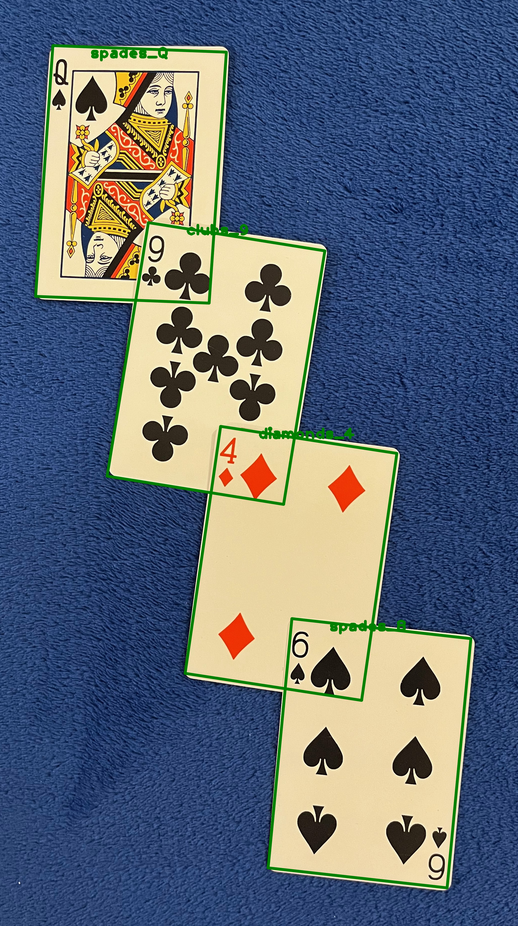

In [35]:
result_img_annotated = img_to_process_color.copy()

for quad, face, _ in refined_found_data:
    result_img_annotated = cv2.polylines(result_img_annotated, [np.int32(quad)], True, (0, 128, 0), 10, cv2.LINE_AA)
    cv2.putText(result_img_annotated, face, tuple(np.int32(order_ccw(quad)[0])+[150, 50]), cv2.FONT_HERSHEY_PLAIN, 4, (0, 128, 0), 10)

display_scaled(result_img_annotated, 0.25)

Ezt a cellát arra használtam, hogy az eredményeket képként lementsem.

In [ ]:
'''
import os

REFERENCES_DIR = "refs3"
reference_card_data = process_reference_images(REFERENCES_DIR, verbose=0)
DISTANCE_RATIO = 0.9
MAX_ITERS = 25000

for file in Path('pics3').rglob("*"):
        if not file.is_file(): continue
        kp, des, img_to_process_color, img_to_process_masked = process_image(str(file), verbose=0)
        found_data = find_cards(reference_card_data, kp, des, distance_ratio=DISTANCE_RATIO, max_iters=MAX_ITERS, verbose=0)
        refined_found_data = refine_found_data(found_data, img_to_process_color, verbose=0)
        result_img_annotated = img_to_process_color.copy()
        for quad, face, _ in refined_found_data:
                result_img_annotated = cv2.polylines(result_img_annotated, [np.int32(quad)], True, (0, 0, 128), 10, cv2.LINE_AA)
                cv2.putText(result_img_annotated, face, tuple(np.int32(order_ccw(quad)[0])+[50, 25]), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 128), 6)
        output_filename = os.path.join('results', file.stem + "_annotated.png")
        cv2.imwrite(output_filename, result_img_annotated)
'''